In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# August 2024
# License: MIT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [3]:
# Load the digits dataset
X, y = load_digits(return_X_y=True)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Define a list of models to compare
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', HistGradientBoostingClassifier()),
    ('SVM', SVC()),
    ('MLP', MLPClassifier())
]

In [5]:
# Conduct experiments
n_seeds = 3  # Number of random seeds
results = {} # Results dictionary to store mean accuracies and training times

# Run each algorithm with different seeds
for name, model in models:
    model_scores = []
    training_times = []
    
    for seed in range(42, 42 + n_seeds):
        # Set random state for reproducibility
        if 'random_state' in model.get_params():
            model.set_params(random_state=seed)
        
        # Define cross-validation procedure
        cv = KFold(n_splits=5, shuffle=True, random_state=seed)
        for train_index, test_index in cv.split(X_train):
            X_cv_train, X_cv_test = X_train[train_index], X_train[test_index]
            y_cv_train, y_cv_test = y_train[train_index], y_train[test_index]

            # Measure training time
            start_time = time.time()
            model.fit(X_cv_train, y_cv_train)
            end_time = time.time()

            # Calculate training time for this fold
            training_time = end_time - start_time
            training_times.append(training_time)

            # Predict and score the model
            score = model.score(X_cv_test, y_cv_test)
            model_scores.append(score)
    
    # Store the mean accuracy and standard error
    results[name] = {
        'mean_accuracy': np.mean(model_scores),
        'std_error': np.std(model_scores) / np.sqrt(len(model_scores) * n_seeds),
        'mean_training_time': np.mean(training_times)
    }

In [6]:
# Report results
df = pd.DataFrame.from_dict(results, orient='index')
print(df)

                     mean_accuracy  std_error  mean_training_time
Logistic Regression       0.968686   0.001198            0.032515
KNN                       0.971696   0.001538            0.001196
Random Forest             0.971926   0.001569            0.349858
Gradient Boosting         0.967756   0.001159            3.933325
SVM                       0.980508   0.001241            0.054964
MLP                       0.975640   0.001563            1.096040


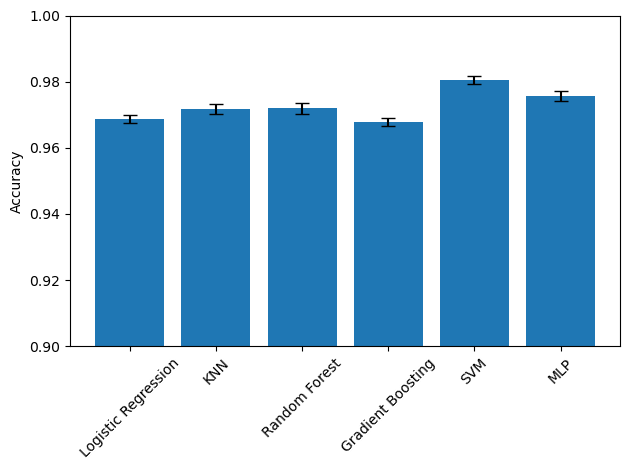

In [7]:
# Plot accuracy results
accuracies = [metrics['mean_accuracy'] for metrics in results.values()]
std_errors = [metrics['std_error'] for metrics in results.values()]
model_names = list(results.keys())

plt.bar(model_names, accuracies, yerr=std_errors, capsize=5)
plt.ylabel('Accuracy')
plt.ylim([0.9, 1.0])  # Adjust based on actual accuracies
plt.xticks(rotation=45)
plt.tight_layout() 
plt.savefig('figures/model_comparison_accuracy.pdf', bbox_inches='tight')

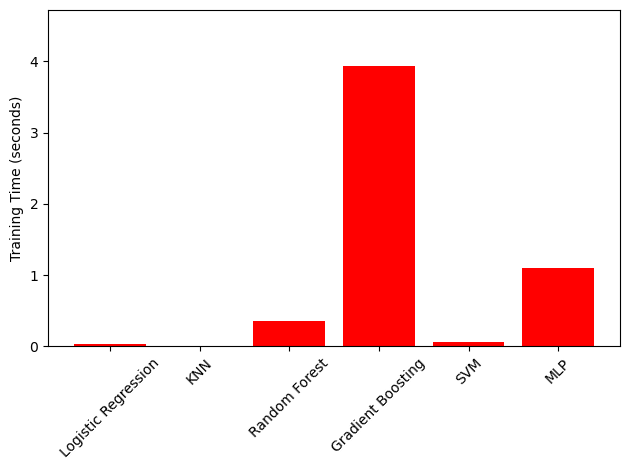

In [8]:
# Plot training times
training_times = [results[name]['mean_training_time'] for name in model_names]

plt.bar(model_names, training_times, color='red')
plt.ylabel('Training Time (seconds)')
plt.ylim([0, max(training_times) * 1.2])  
plt.xticks(rotation=45)
plt.tight_layout() 
plt.savefig('figures/model_comparison_training_time.pdf', bbox_inches='tight')

In [9]:
# Final evaluation on the test set
test_results = {}
for name, model in models:
    # Retrain each model on the full training set
    if 'random_state' in model.get_params():
        model.set_params(random_state=42)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    test_results[name] = accuracy

# Print out the test accuracy for each model
print("Test Set Performance:")
for model_name, test_accuracy in test_results.items():
    print(f"{model_name}: Accuracy = {test_accuracy:.4f}")

Test Set Performance:
Logistic Regression: Accuracy = 0.9722
KNN: Accuracy = 0.9750
Random Forest: Accuracy = 0.9722
Gradient Boosting: Accuracy = 0.9750
SVM: Accuracy = 0.9806
MLP: Accuracy = 0.9806
